### Model Utilization
使用之前通过keras生成的模型进行数据集的分析，并提取信息

In [2]:
from keras.models import load_model
import numpy as np
import pandas as pd
import jieba
import gensim, logging
from gensim.models import word2vec
from sklearn.cross_validation import train_test_split
from keras.layers import Dense, Dropout, Activation
from sklearn.metrics import f1_score
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# load model
MLPmodel = load_model("outputs/MLPmodel.h5")
LSTMmodel = load_model("outputs/LSTMmodel.h5")

In [4]:
def score(model, text):
    def getWordVecs(wordList):
        W2Vmodel = word2vec.Word2Vec.load("W2Vmodel\CommentsW2V.model")
        vecs = []
        for word in wordList:
            word = word.replace('\n', '')
            try:
                vecs.append(W2Vmodel[word])
            except KeyError:
                continue
        return np.array(vecs, dtype = 'float')
    try:
        seg_list = jieba.cut(text, cut_all=False)
        w2cTest = getWordVecs(list(seg_list))
        shapedVector = sum(np.array(w2cTest))/len(w2cTest)
        return model.predict_proba(np.array([shapedVector]))[0][0]
    except Exception as err:
        seg_list = jieba.cut(text, cut_all=False)
        w2cTest = getWordVecs(list(seg_list))
        shapedVector = sum(np.array(w2cTest))/len(w2cTest)
        shapedVector = np.array([shapedVector]);
        reshapedVector = np.reshape(shapedVector, (shapedVector.shape[0], 1, shapedVector.shape[1]))
        return model.predict_proba(reshapedVector)[0][0]
    
def score2(text):
    return (score(MLPmodel, text) + score(LSTMmodel, text))/2

In [20]:
score(MLPmodel, "非常喜欢")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


0.014987839

In [6]:
# 读取数据
data = pd.read_csv("inputs\MovieComments1.csv", encoding="gb18030", header=None, 
                  names = ["MovieName","comment","score","user","datatime","votes","UserUrl","CommentUrl"])
data.head(5)

,MovieName,comment,score,user,datatime,votes,UserUrl,CommentUrl
0,马戏之王 短评,故事講得不怎麽樣，依舊把少數人群當作噱頭的感覺；但忍不住抖腿。又唱又跳的休叔加上又唱又跳的...,推荐,Bosie,2017-12-28 00:31:54,34,https://www.douban.com/people/jeskovampire/,https://movie.douban.com/subject/3914513/comme...
1,马戏之王 短评,娱乐电影的本质还是视觉奇观和欢乐。,推荐,张小北,2018-02-04 17:36:08,37,https://www.douban.com/people/xzfd/,https://movie.douban.com/subject/3914513/comme...
2,马戏之王 短评,非常享受，作为串联歌舞的情节竟然也也颇有可看之处，倒是有点超出预期。酒吧的两场最好，高空飞...,推荐,艾小柯,2018-02-17 21:04:16,16,https://www.douban.com/people/aixiaoke/,https://movie.douban.com/subject/3914513/comme...
3,马戏之王 短评,3.5。1.这个马戏团，居然没有小丑，不开心！2.歌舞场面自然是最大看点，设计上花了不少心...,推荐,陆支羽,2018-02-05 14:30:58,15,https://www.douban.com/people/luzhiyu/,https://movie.douban.com/subject/3914513/comme...
4,马戏之王 短评,歌舞部分很燃，休叔一跳起舞来真的是帅啊！但抛开歌舞部分不谈，剧本就是个屌丝逆袭的故事，底层...,推荐,我要加油,2018-02-04 00:08:31,83,https://www.douban.com/people/172453309/,https://movie.douban.com/subject/3914513/comme...


### 以用户为目标的系列短评分析
首先需要提取出发表过评论多于20个的用户，他们的评论才是有效的。

In [7]:
data['user'].value_counts()[lambda x: x > 20].head(10)

康报虹         46
痞影人科莱昂      39
西楼尘         36
陆支羽         33
王大根         32
同志亦凡人中文站    31
徐若风         31
桃桃淘电影       30
Panda的阴影    30
[已注销]       30
Name: user, dtype: int64

提取名字为XX的评论和打分的dataframe，对每条评论判断情感值, 最后给出一个总的用户情感倾向，并绘制时间情感图

In [8]:
username = '王大根'
icomment = data[data['user']==username][['comment', 'score', 'datatime']]
# 按时间序列排序
icomment = icomment.sort_values(by=['datatime'])

In [9]:
score_list = []
count = 0
for i in range(0,len(icomment)):
    iscore = score2(icomment.iloc[i]['comment'])
    score_list.append(iscore)
    count += 1
    if count < 6:
        print('comment:\n' + icomment.iloc[i]['comment'])
        print('True score:' + icomment.iloc[i]['score'])
        print('Forecast score:\n' + str(iscore))
        print()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


comment:
 比《寄生兽》差太多了，最崩溃的是以为终于看了一部避开福士苍汰的漫改，结果出来一个铃木伸之比福士苍汰还福士苍汰……
True score:较差
Forecast score:
0.5855273008346558

comment:
 Ryan Reynold演龟毛丧逼比演死侍好笑！不过总感觉抢了Paul Rudd饭碗
True score:推荐
Forecast score:
0.03427726775407791

comment:
 比《鲛珠传》还《银河护卫队》啊，很可能是目前最具太空科幻感的国产电影了！
True score:推荐
Forecast score:
0.1276332587003708

comment:
 太可爱了，超能男子高中生的日常
True score:推荐
Forecast score:
0.0015576196601614356

comment:
 要在一部青春片里看见李鸿其应该都不会多看两眼，在这片里一衬托，妈呀看完火速下载他之前演的同志电影了！
True score:还行
Forecast score:
0.359286367893219



In [10]:
# total score of user
print("user:" + username)
print("avg_score:" + str(sum(score_list)/len(score_list)))

user:王大根
avg_score:0.5029792292734783


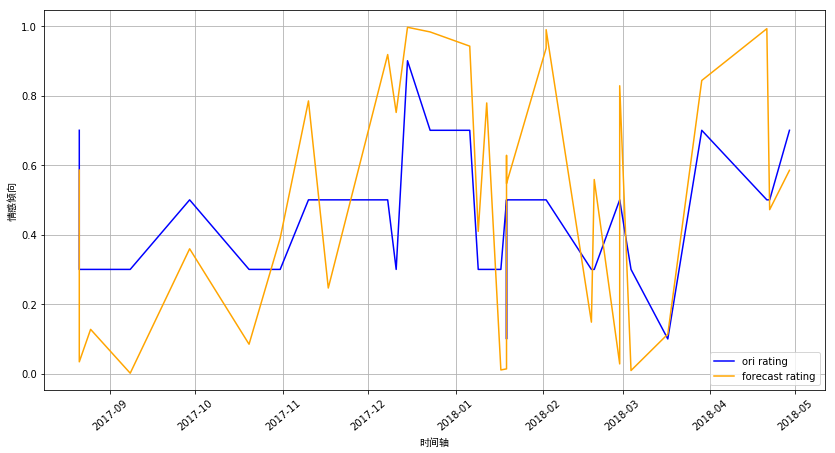

In [11]:
# 将汉字转化为0-1之间的小数
rating_convert = {'力荐':0.1, '推荐':0.3, '还行':0.5, '较差':0.7, '很差':0.9} 
converted_rating = list(map(lambda x: rating_convert[x], icomment['score']))

xs = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S').date() for d in icomment['datatime']]
plt.figure(figsize=(14,7))
plt.plot(xs, pd.Series(converted_rating),label = 'ori rating', color='blue')
plt.plot(xs, score_list, label='forecast rating', color='orange')

plt.ylabel(u'情感倾向',fontproperties='SimHei')
plt.xlabel(u'时间轴',fontproperties='SimHei')
plt.xticks(rotation=40)
plt.legend(loc = 'lower right') 
plt.grid(True)
plt.show()

### 以电影为目标的系列短评分析
首先查看有哪些电影评论数较多，选取前10个查看

In [12]:
data['MovieName'].value_counts()[lambda x: x > 20].head(10)

啊，荒野 前篇 短评       166
追捕 短评            160
荒城纪 短评           160
茉莉牌局 短评          160
猫与桃花源 短评         160
大坏狐狸的故事 短评       160
马斯顿教授与神奇女侠 短评    160
我能说 短评           160
海滩的一天 短评         145
奇门遁甲 短评          140
Name: MovieName, dtype: int64

In [13]:
moviename='马戏之王 短评'
imovie = data[data['MovieName']==moviename][['comment', 'score', 'datatime']]
# 按时间序列排序
imovie = imovie.sort_values(by=['datatime'])

In [14]:
score_list = []
count = 0
for i in range(0,len(imovie)):
    iscore = score2(imovie.iloc[i]['comment'])
    score_list.append(iscore)
    count += 1
    if count < 6:
        print('comment:\n' + imovie.iloc[i]['comment'])
        print('True score:' + imovie.iloc[i]['score'])
        print('Forecast score:\n' + str(iscore))
        print()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


comment:
 又有机会听到休叔唱“gay我一个碗~”之外的歌，先给五星好评啊！
True score:力荐
Forecast score:
0.0007836141157895327

comment:
 再次见识到zac的歌唱实力 加入杂戏元素 心脏跳好快 开头结尾棒 中间剧情…emmm…电影院看歌剧类电影还是很值票价
True score:推荐
Forecast score:
0.08321212232112885

comment:
 多打一星 因为共鸣 当中听完歌剧被拒之门外然后走出来 this is me不禁泪奔 作为LGBTQ的empathy 音乐歌舞赞爆 每一段都超赞 角色众多 在时代广场AMC看到 同场有里面演出的一位小配角和他的朋友们 不断掌声 很热闹 看的很开心很感动 休叔唱歌跳舞都棒棒哒
True score:力荐
Forecast score:
0.0004172814660705626

comment:
 多一颗星给Rebecca Ferguson和Never Enough，真的是全剧最亮的星，所以婚外恋没能展开让我很是失望……基本上全片中心思想就是一首歌解决不了的问题总可以用两首歌解决，所有危机都是瞬间化解，但是节日里看着合家欢乐一下的效果还是非常好的。狼叔真是帅到360度无死角，相比之下Zac Efron立刻相形见绌
True score:推荐
Forecast score:
0.7925461530685425

comment:
 如同在电影院看了一场歌舞剧，连表演方式上都延续舞台剧的夸张，情节非常普通，但是歌舞场面非常非常燃。
True score:推荐
Forecast score:
0.7448772192001343



In [15]:
# total score of movie
print("movie:" + moviename)
print("avg_score:" + str(sum(score_list)/len(score_list)))

movie:马戏之王 短评
avg_score:0.5434390262445958


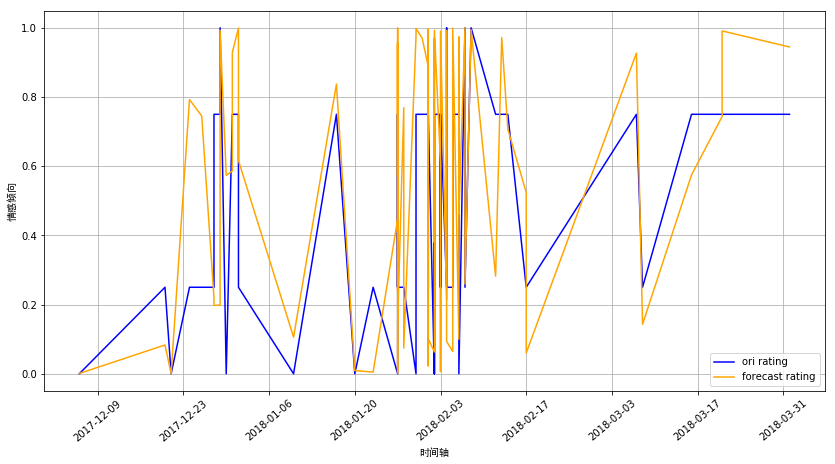

In [17]:
# 将汉字转化为0-1之间的小数
rating_convert = {'力荐':0.0, '推荐':0.25, '还行':0.5, '较差':0.75, '很差':1.0} 
converted_rating = list(map(lambda x: rating_convert[x], imovie['score']))

xs = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S').date() for d in imovie['datatime']]
plt.figure(figsize=(14,7))
plt.plot(xs, pd.Series(converted_rating),label = 'ori rating', color='blue')
plt.plot(xs, score_list, label='forecast rating', color='orange')

plt.ylabel(u'情感倾向',fontproperties='SimHei')
plt.xlabel(u'时间轴',fontproperties='SimHei')
plt.xticks(rotation=40)
plt.legend(loc = 'lower right') 
plt.grid(True)
plt.show()